To do the sunrise/sunset calculations you'll need to do:

```
conda install dateutil
conda install ephem
```

On windows, you can get an ncdump executable [here](http://www.unidata.ucar.edu/software/netcdf/docs/winbin.html)

In [1]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import glob
from netCDF4 import Dataset
from dateutil.parser import parse
import datetime
import numpy as np
import matplotlib.dates as mdates

# grab August

filelist=['cesar_nubiscope_cloudcover_la1_t10_v1.0_201407.nc',
          'cesar_nubiscope_cloudcover_la1_t10_v1.0_201408.nc',
          'cesar_surface_flux_lc1_t10_v1.0_201407.nc',
          'cesar_surface_flux_lc1_t10_v1.0_201408.nc',
          'cesar_surface_meteo_lc1_t10_v1.0_201407.nc',
          'cesar_surface_meteo_lc1_t10_v1.0_201408.nc',
          'cesar_tower_meteo_lb1_t10_v1.1_201407.nc',
          'cesar_tower_meteo_lb1_t10_v1.1_201408.nc']

In [3]:
import urllib
data_download=False
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/cabauw/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)

The make_date function takes an open CESAR ncfile and turns the time
vector from hours past the start date into a python datetime object
in UTC.  It uses the dateutil parse function to turn the date_start_of_data
string into a date.

In [4]:
def make_date(ncfile):
    """
    ncfile:  open netCDF4 Dataset
    returns:
       numpy array of datetime objects
    """
    the_time=f.variables['time'][...]
    start_date=f.variables['product'].date_start_of_data
    start_date = parse(start_date)
    time_vec=[]
    for the_hour in the_time:
        time_vec.append(start_date + datetime.timedelta(hours=float(the_hour)))
    time_vec=np.array(time_vec)
    return time_vec


Loop through all the files and make a dictionary with keys determined
by the netcdf file attributes.  Initially the dictionary contains the
filename, start_date, lat, lon and start time.

In [5]:
all_files=glob.glob('cesar*.nc')
data_dict={}
for the_file in all_files:
    with Dataset(the_file,'r') as f:
        details=f.variables['iso_dataset']
        attributes=details.ncattrs()
        attr_dict={}
        for attr in attributes:
            attr_dict[attr]=getattr(details,attr)
        lon=attr_dict['westbound_longitude']
        lat=attr_dict['northbound_latitude']
        title=attr_dict['title'].split()
        the_time = make_date(f)
        #
        # turn a title like:
        #"CESAR surface fluxes validated and gap filled"
        # into the string: surface_fluxes
        #
        filetype='{}_{}'.format(*title[1:3])
        start_date=f.variables['product'].date_start_of_data
        start_date=parse(start_date)
        start_month=start_date.strftime('%Y%m')
    data_dict[filetype,start_month]=dict(name=the_file,start=start_date,lat=lat,lon=lon,
                                         time=the_time)
print(data_dict.keys())    

dict_keys([('surface_fluxes', '201407'), ('tower_meteorological', '201408'), ('surface_fluxes', '201408'), ('meteorological_surface', '201408'), ('tower_meteorological', '201407'), ('meteorological_surface', '201407'), ('scanning_radiometer', '201407'), ('scanning_radiometer', '201408')])


Now loop through the dictionary and add the flux and tower variables.
Each variable is a linear vector of measurements taken every 10 minutes, and
for tower variables, at 7 levels.

The numpy command:
var.reshape(-1,24,6,7)
takes the linear vector and folds it into either 28,29,30,31 days (depending on monty)
24 hours, 6 10 minute intervals, and 7 levels

That allows us to do an hourly average by saying:
var.mean(axis=2)  to average over the 6 10 minute measurements.

In [6]:
for the_key in data_dict.keys():
    if the_key[0] == 'tower_meteorological':
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            var_dict['z'] = f.variables['z'][...]
            for var in ['F','TA','TD','Q']:
                var_dict[var] = f.variables[var][...].reshape(-1,24,6,7)
    elif the_key[0] == 'surface_fluxes': 
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            for var in ['H','UST','LE']:
                var_dict[var] = f.variables[var][...]
    elif the_key[0] == 'meteorological_surface': 
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            for var in ['P0']:
                var_dict[var] = f.variables[var][...]
    elif the_key[0] == 'scanning_radiometer':
        pass
    else:
        raise ValueError("didn't recognize {}".format(the_key[0]))

We'll need to know sunrise, sunset and solar noon to interpret our
data.  Here is how you find these with the 
[pyephem](http://stackoverflow.com/questions/2637293/calculating-dawn-and-sunset-times-using-pyephem) module

In [7]:
month=['201407','201408']
import ephem
for the_month in month:
    var='tower_meteorological'
    tower_dict=data_dict[var,the_month]
    start_time=tower_dict['time'][0]
    cabauw=ephem.Observer()
    cabauw.date=start_time
    cabauw.lon = tower_dict['lon']
    cabauw.lat = tower_dict['lat']
    sunrise=cabauw.next_rising(ephem.Sun())
    noon = cabauw.next_transit(ephem.Sun(),start=sunrise)
    sunset = cabauw.next_setting(ephem.Sun())
    print('sunrise is {} UTC'.format(sunrise))
    print('solar noon {} UTC'.format(noon))
    print('sunset is {} UTC'.format(sunset))

sunrise is 2014/7/1 03:24:19 UTC
solar noon 2014/7/1 11:44:09 UTC
sunset is 2014/7/1 20:03:38 UTC
sunrise is 2014/8/1 04:01:34 UTC
solar noon 2014/8/1 11:46:39 UTC
sunset is 2014/8/1 19:30:41 UTC


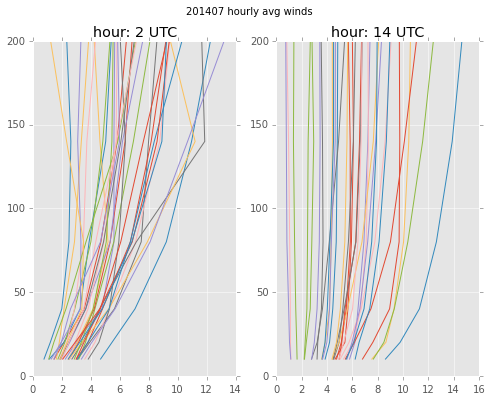

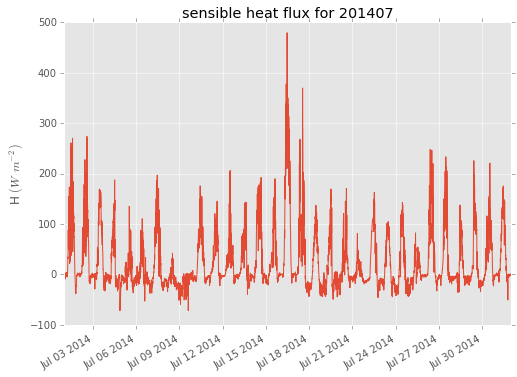

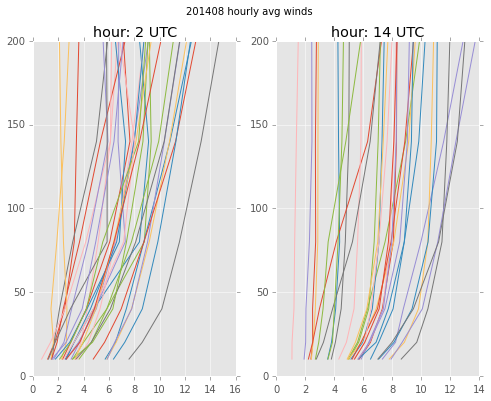

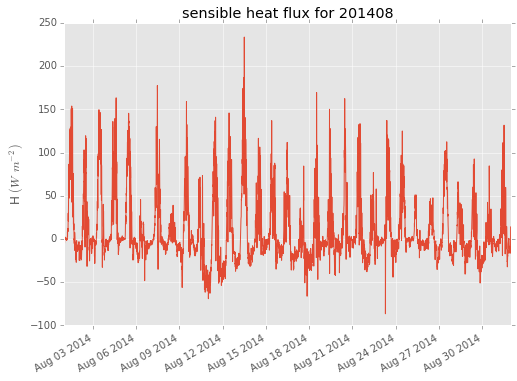

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.close('all')
    
var='tower_meteorological'
tower_dict=data_dict[var,the_month]
the_times=tower_dict['time'].reshape(-1,24,6)    


for the_month in month:
    var='tower_meteorological'
    tower_dict=data_dict[var,the_month]
    hourly_wind_avg=tower_dict['F'].mean(axis=2)
    z=tower_dict['z']
    
    hour=2
    fig,ax=plt.subplots(1,2,figsize=(8,6))
    ax[0].plot(hourly_wind_avg[:,hour,:].T,z)
    ax[0].set(title='hour: {} UTC'.format(hour))
    hour=14
    ax[1].plot(hourly_wind_avg[:,hour,:].T,z)
    ax[1].set(title='hour: {} UTC'.format(hour))
    fig.suptitle('{} hourly avg winds'.format(the_month))

    #
    # date plotting tips at http://matplotlib.org/users/recipes.html
    #
    var='surface_fluxes'
    flux_dict=data_dict[var,the_month]

    fig,ax=plt.subplots(1,1,figsize=(8,6))
    fig.autofmt_xdate()
    ax.plot(flux_dict['time'],flux_dict['H'])
    title='sensible heat flux for {}'.format(the_month)
    ax.set(title=title,ylabel='H $(W\,m^{-2})$')


In [9]:
def theta(p,T):
    """
      input: p (Pa), scalar pressure
             T (K),  scalar or array of temperatures
      output: thetaval (K) potential temperature
    """
    Rd=287  #dry air gas constant  J/kg/K
    cp=1004.  #dry air heat capacity at constant pressure (J/kg/K)
    p0=1.e5  #reference pressure (Pa)
    the_exp=Rd/cp
    thetaval=T*(p0/p)**the_exp
    return thetaval


[ 0.00167996  0.22888782  0.00361222 ...,  0.00403814  0.00453354
 -0.01130735]


(-10, 10)

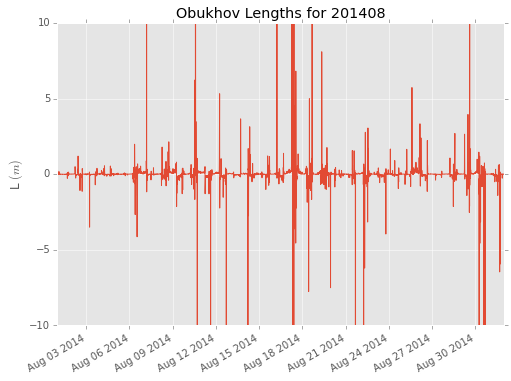

In [10]:
# calculate Obukhov lengths

# constants

k = 0.40
g = 9.81

# calculate average temperatures  
average_temp = np.array(tower_dict['TA'].mean(axis=3)).flat

# calculate L array
L_array = np.empty_like(flux_dict['H'])
L_array = -(flux_dict['UST']**3)*average_temp/(k*g*flux_dict['H'])
print(L_array)

fig,ax=plt.subplots(1,1,figsize=(8,6))
fig.autofmt_xdate()
ax.plot(flux_dict['time'],L_array)
title='Obukhov Lengths for {}'.format(the_month)
ax.set(title=title,ylabel='L $(m)$') 
ax.set_ylim([-10, 10])

In [11]:
!ncdump cesar_surface_flux_lc1_t10_v1.0_201408.nc

netcdf cesar_surface_flux_lc1_t10_v1.0_201408 {
dimensions:
	time = UNLIMITED ; // (4464 currently)
	nv = 2 ;
	day_in_time_interval = 31 ;
variables:
	char iso_dataset ;
		iso_dataset:hierarchyLevel = "dataset" ;
		iso_dataset:url = "http://www.cesar-database.nl" ;
		iso_dataset:protocol = "website" ;
		iso_dataset:topic = "climatologyMeteorologyAtmosphere" ;
		iso_dataset:westbound_longitude = "4.926" ;
		iso_dataset:eastbound_longitude = "4.926" ;
		iso_dataset:southbound_latitude = "51.97" ;
		iso_dataset:northbound_latitude = "51.97" ;
		iso_dataset:datasetDateType = "publication" ;
		iso_dataset:code = "28992" ;
		iso_dataset:codeSpace = "EPSG" ;
		iso_dataset:accessConstraints = "CESAR data policy" ;
		iso_dataset:useLimitation = "None" ;
		iso_dataset:organisationName_dataset = "Royal Netherlands Meteorological Institute (KNMI)" ;
		iso_dataset:email_dataset = "fred.bosveld@knmi.nl" ;
		iso_dataset:role_dataset = "Principle Investigator" ;
		iso_dataset:organisationName_metadata

In [12]:
!ncdump cesar_surface_meteo_lc1_t10_v1.0_201408.nc

netcdf cesar_surface_meteo_lc1_t10_v1.0_201408 {
dimensions:
	time = UNLIMITED ; // (4464 currently)
	nv = 2 ;
	day_in_time_interval = 31 ;
variables:
	char iso_dataset ;
		iso_dataset:hierarchyLevel = "dataset" ;
		iso_dataset:url = "http://www.cesar-database.nl" ;
		iso_dataset:protocol = "website" ;
		iso_dataset:topic = "climatologyMeteorologyAtmosphere" ;
		iso_dataset:westbound_longitude = "4.926" ;
		iso_dataset:eastbound_longitude = "4.926" ;
		iso_dataset:southbound_latitude = "51.97" ;
		iso_dataset:northbound_latitude = "51.97" ;
		iso_dataset:datasetDateType = "publication" ;
		iso_dataset:code = "28992" ;
		iso_dataset:codeSpace = "EPSG" ;
		iso_dataset:accessConstraints = "CESAR data policy" ;
		iso_dataset:useLimitation = "None" ;
		iso_dataset:organisationName_dataset = "Royal Netherlands Meteorological Institute (KNMI)" ;
		iso_dataset:email_dataset = "fred.bosveld@knmi.nl" ;
		iso_dataset:role_dataset = "Principle Investigator" ;
		iso_dataset:organisationName_metadat

In [13]:
!ncdump cesar_tower_meteo_lb1_t10_v1.1_201408.nc

netcdf cesar_tower_meteo_lb1_t10_v1.1_201408 {
dimensions:
	time = UNLIMITED ; // (4464 currently)
	nv = 2 ;
	day_in_time_interval = 31 ;
	z = 7 ;
variables:
	char iso_dataset ;
		iso_dataset:hierarchyLevel = "dataset" ;
		iso_dataset:url = "http://www.cesar-database.nl" ;
		iso_dataset:protocol = "website" ;
		iso_dataset:topic = "climatologyMeteorologyAtmosphere" ;
		iso_dataset:westbound_longitude = "4.926" ;
		iso_dataset:eastbound_longitude = "4.926" ;
		iso_dataset:southbound_latitude = "51.97" ;
		iso_dataset:northbound_latitude = "51.97" ;
		iso_dataset:datasetDateType = "publication" ;
		iso_dataset:code = "28992" ;
		iso_dataset:codeSpace = "EPSG" ;
		iso_dataset:accessConstraints = "CESAR data policy" ;
		iso_dataset:useLimitation = "None" ;
		iso_dataset:organisationName_dataset = "Royal Netherlands Meteorological Institute (KNMI)" ;
		iso_dataset:email_dataset = "fred.bosveld@knmi.nl" ;
		iso_dataset:role_dataset = "Principle Investigator" ;
		iso_dataset:organisationName_

In [14]:
# from bussinger_dyer.ipynb

import numpy as np
from numpy import log,arctan,pi
import matplotlib.pyplot as plt


def surfaceScale(zeta,zz0):
    """
       zeta= z/L
       zz0 = z/roughness length
       
       stull equations 7.4.11
       zeta can be either a number (scalar)
       or a vector
    """
    #
    # the function monin always returns a numpy array
    # if we pass zeta as a scalar, unpack that array
    # and return the drag coefficients as scalars
    #
    is_scalar=False
    if np.isscalar(zeta):
        is_scalar = True   
    (psim,psih)=monin(zeta)
    k=0.4
    CD=k**2/(log(zz0) - psim)**2.
    CH=(k**2.)/(log(zz0) - psim)/(log(zz0) - psih)
    CDN=(k**2.)/(log(zz0)**2.)
    CHN=CDN
    if is_scalar:
        CD=CD[0]
        CH=CH[0]
    return (CD,CH,CDN,CHN)

def monin(zeta):
    #Bussinger-dyer relationships (Stull p. 383, eq. 9.7.5)
    #or Fleagle and Bussinger page 180.
    zeta=np.atleast_1d(zeta)
    psim=np.empty_like(zeta)
    psih=np.empty_like(zeta)
    for i,the_zeta in enumerate(zeta):
        if the_zeta < 0:
           x=(1 - 16*the_zeta)**(0.25)
           psim[i]=log(((1+x**2.)/2.)*((1+x)/2.)**2.) - 2.*arctan(x) + pi/2.
           psih[i]=2.*log((1.+x**2.)/2.)
        elif (the_zeta > 0):
           psim[i]= -5.*the_zeta
           psih[i]= -5.*the_zeta
        else:
          psim[i]=0.
          psih[i]=0.
    return (psim,psih)

In [15]:
# calculate average ubar/ustar and zeta for three different hours across all tower heights
hour_indices = np.arange(0,6)

# August 3rd 06:00 
hour1 = 6
hour_indices1 = hour_indices + (2*144) + (hour1*6)
ustar1 = np.average(flux_dict['UST'][hour_indices1])
ubar1 = hourly_wind_avg[2, hour1, :]
#uustar1 = ubar1/ustar1
zeta1 =  z/np.average(L_array[hour_indices1])

# August 3rd 12:00
hour2 = 12
hour_indices2 = hour_indices + (2*144) + (hour2*6)
ustar2 = np.average(flux_dict['UST'][hour_indices2])
ubar2 = hourly_wind_avg[2, hour2, :]
#uustar2 = ubar2/ustar2
zeta2 =  z/np.average(L_array[hour_indices2])

# August 3rd 18:00
hour3 = 18
hour_indices3 = hour_indices + (2*144) + (hour3*6)
ustar3 = np.average(flux_dict['UST'][hour_indices3])
ubar3 = hourly_wind_avg[2, hour3, :]
#uustar3 = ubar3/ubar3
zeta3 =  z/np.average(L_array[hour_indices3])

# assume roughness length for short grass, from Stull Fig. 9.6
z0 = 10e-2
zz0 = z/z0

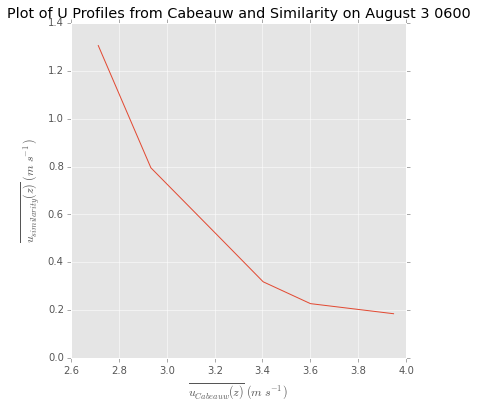

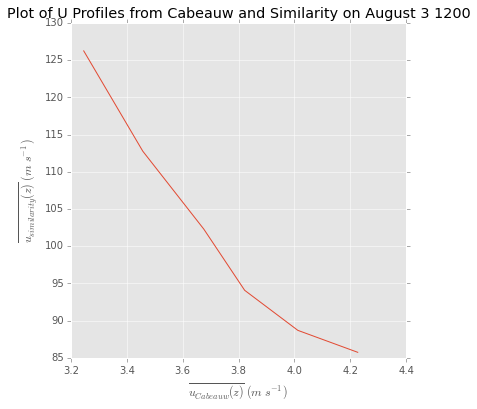

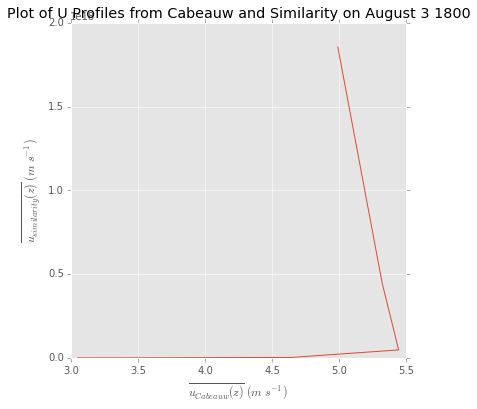

In [16]:
# calculate drag coeffs for all three times
CD1,CH1,CDN1,CHN1 = surfaceScale(zeta1, zz0)
CD2,CH2,CDN2,CHN2 = surfaceScale(zeta2, zz0)
CD3,CH3,CDN3,CHN3 = surfaceScale(zeta3, zz0)

# find the analytic ubar
ubar1_analytic = CD1**(-2)*ustar1
ubar2_analytic = CD2**(-2)*ustar2
ubar3_analytic = CD3**(-2)*ustar3

# plot results
fig1, ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.plot(ubar1, ubar1_analytic)
ax1.set(title='Plot of U Profiles from Cabeauw and Similarity on August 3 0600', 
        ylabel=r'$\overline{u_{similarity}(z)}\ (m\ s^{-1})$',
        xlabel=r'$\overline{u_{Cabeauw}(z)}\ (m\ s^{-1})$')

fig2, ax2 = plt.subplots(1,1,figsize=(6,6))
ax2.plot(ubar2, ubar2_analytic)
ax2.set(title='Plot of U Profiles from Cabeauw and Similarity on August 3 1200', 
        ylabel=r'$\overline{u_{similarity}(z)}\ (m\ s^{-1})$',
        xlabel=r'$\overline{u_{Cabeauw}(z)}\ (m\ s^{-1})$')

fig3, ax3 = plt.subplots(1,1,figsize=(6,6))
ax3.plot(ubar3, ubar3_analytic)
ax3.set(title='Plot of U Profiles from Cabeauw and Similarity on August 3 1800', 
        ylabel=r'$\overline{u_{similarity}(z)}\ (m\ s^{-1})$',
        xlabel=r'$\overline{u_{Cabeauw}(z)}\ (m\ s^{-1})$')
